In [1]:
import sys
sys.path.append("../legacy/")
import os
import ot
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import geopandas
from libpysal import weights
from gerrychain import Graph
import total
import utils

img_dir = os.path.join(".", "figs")

/tmp/ipykernel_72854/137562230.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


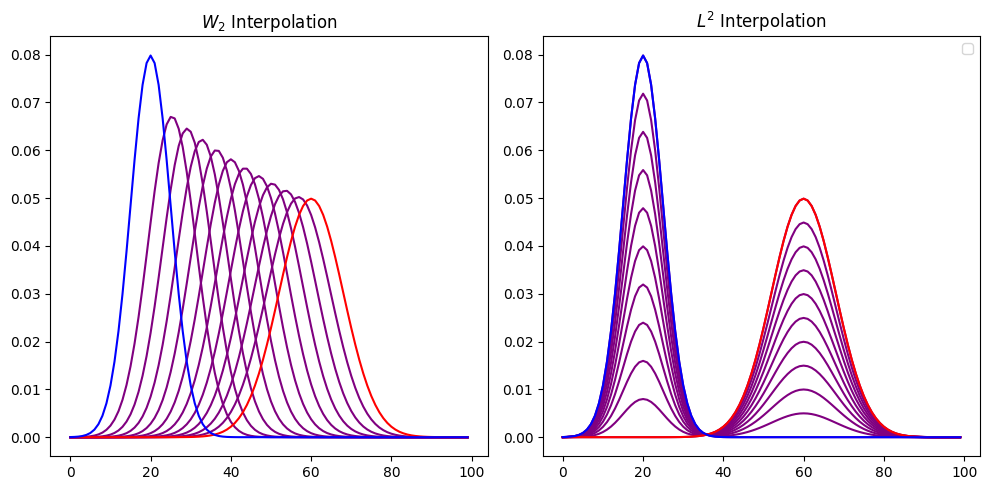

In [2]:
n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a1 = ot.datasets.make_1D_gauss(n, m=20, s=5)  # m= mean, s= std
a2 = ot.datasets.make_1D_gauss(n, m=60, s=8)

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, num=1)
inches = 5
fig.set_size_inches(2 * inches, inches)
# wasserstein
for i in range(1,11):
    alpha = 0.1 * i  # 0<=alpha<=1
    w= np.array([1 - alpha, alpha])
    reg = 1e-3
    bary_wass = ot.bregman.barycenter(A, M, reg, w)
    ax1.plot(x, bary_wass, "purple")
ax1.plot(x, a2, color="red")
ax1.plot(x, a1, color="blue")
ax1.set_title(r"$W_2$ Interpolation")

for i in range(11):
    alpha = 0.1 * i  # 0<=alpha<=1
    w= np.array([1 - alpha, alpha])
    bary_l2 = A.dot(w)
    ax2.plot(x, bary_l2, "purple")

ax2.plot(x, a2, color="red")
ax2.plot(x, a1, color="blue")
ax2.set_title(r"$L^2$ Interpolation")

plt.legend()
plt.savefig(os.path.join(img_dir,"interpolants.pdf"))

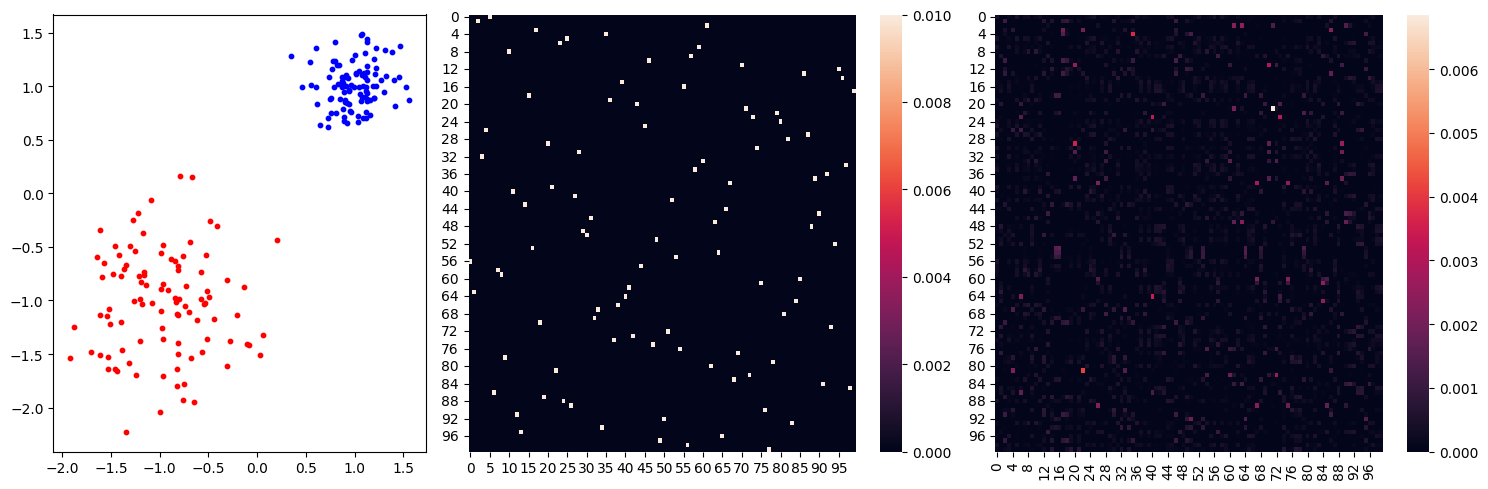

In [3]:
# illustrate transport interpolation vs L2 interpolations
n = 100
X_mean = [-1, -1]
Y_mean = [1, 1]
X_cov = [[0.25, 0], [0, 0.25]]
Y_cov = [[0.05, 0], [0, 0.05]]
X = np.random.multivariate_normal(X_mean, X_cov, n)
Y = np.random.multivariate_normal(Y_mean, Y_cov, n)
M = ot.dist(X,Y)
M.shape
a, b = np.ones((n,)) / n, np.ones((n,)) / n
G = ot.emd(a, b, M)
G_epsilon = ot.sinkhorn(a,b,M, 0.05)

fig, ax = plt.subplots(1,3, tight_layout=True,gridspec_kw={'width_ratios': [1, 1.3, 1.3]})
fig.set_size_inches(15,5)
size=10
ax[0].scatter(X.T[0], X.T[1], c='red', s=size)
ax[0].scatter(Y.T[0], Y.T[1], c='blue',s=size)
sns.heatmap(G, ax=ax[1], square=False)
sns.heatmap(G_epsilon, ax=ax[2], square=False)
plt.savefig(os.path.join(img_dir, "plans.pdf"))

In [4]:
import matplotlib.animation as animation
def animate_geodesic(geodesic, metric, filename, steps=50,cmap="magma"):
    fig, ax0 = plt.subplots()
    fig.set_size_inches(10,10)
    def update(frame):
        size = 500
        nx.draw(graph, positions, ax=ax0, node_size=size, node_color=geodesic[:, frame], cmap=cmap)
        ax0.set_title(r"$W_2$ " +  f"Geodesic under {metric}\n Timestep : {frame + 1}")
    ani = animation.FuncAnimation(fig=fig, func=update, frames=steps, interval=100)
    ani.save(filename, writer='ffmpeg')
    return geodesic

In [5]:
def draw_fig(m0, m1, geodesic, coords, fname, size=50, with_labels=False):
    fig, ax = plt.subplots(2,2, tight_layout=True)
    node_color=m0
    nx.draw(
        graph, 
        positions, 
        ax=ax[0][0], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[0][0])
    
    node_color=geodesic[:,T//3]
    nx.draw(
        graph, 
        positions, 
        ax=ax[1][0], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[0][1])
    
    node_color=geodesic[:,2*T//3]
    nx.draw(
        graph, 
        positions, 
        ax=ax[1][1], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[1][0])
    
    node_color=m1
    nx.draw(
        graph, 
        positions, 
        ax=ax[0][1], 
        node_size=size,
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    ax[0][0].set_title(f"Reference Measure")
    ax[0][1].set_title(f"Reference Measure")
    ax[1][0].set_title(f"Actual Coordinate {0.33:}: \nRecovered Coordinate: {coords[1][1]:.4f}")
    ax[1][1].set_title(f"Actual Coordinate {0.66}: \nRecovered Coordinate {coords[2][1]:.4f}")
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[1][1])
    plt.savefig(os.path.join(img_dir, fname))


/home/dcg/projects/bog/.venv/lib/python3.13/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/tmp/ipykernel_72854/1348809296.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((states.centroid.x, states.centroid.y))
/tmp/ipykernel_72854/1348809296.py:10: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(states)


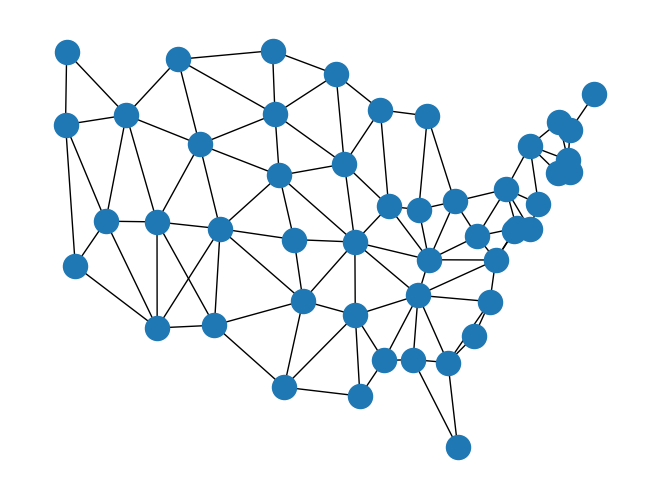

In [3]:
# illustrate different graph metrics
import matplotlib as mpl
from utils import compute_graph_metric, form_diffusion_map_from_graph
filename = "../cces/states/states.shp"
#filename = "../cces/cb_2018_us_state_20m/cb_2018_us_state_20m.shp"
usa_graph = Graph.from_file(filename)
states = geopandas.read_file(filename)
adj_mat = nx.adjacency_matrix(usa_graph).toarray()
centroids = np.column_stack((states.centroid.x, states.centroid.y))
queen = weights.Queen.from_dataframe(states)
graph = queen.to_networkx()
positions = dict(zip(graph.nodes, centroids))
num_nodes = len(graph.nodes)
nx.draw(graph, positions)

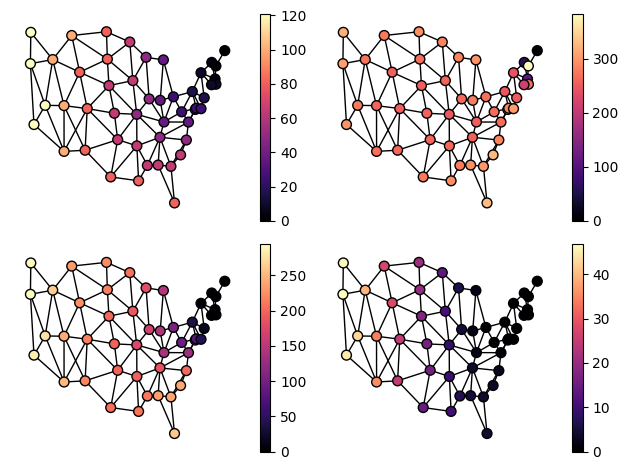

In [7]:
fig, ax = plt.subplots(2,2, tight_layout=True)
sq_shortest_path = compute_graph_metric(graph) ** 2
n = 37
size = 50
with_labels = False
cmap = "magma"

node_color = sq_shortest_path[n]
plot00 = nx.draw(
    graph, 
    positions, 
    ax=ax[0][0], 
    node_size=size, 
    with_labels=with_labels, 
    cmap=cmap,
    node_color=node_color,
    edgecolors="black",
)
vmin = min(node_color)
vmax = max(node_color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=ax[0][0])

node_color=form_diffusion_map_from_graph(graph, 2)[n] ** 3
plot01 = nx.draw(
    graph, 
    positions, 
    ax=ax[0][1], 
    node_size=size, 
    with_labels=with_labels, 
    cmap=cmap,
    edgecolors="black",
    node_color=node_color
)
vmin = min(node_color)
vmax = max(node_color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=ax[0][1])

node_color=form_diffusion_map_from_graph(graph, 8)[n] ** 5
plot10 = nx.draw(
    graph, 
    positions, 
    ax=ax[1][0], 
    node_size=size, 
    with_labels=with_labels, 
    cmap=cmap,
    edgecolors="black",
    node_color=node_color
)
vmin = min(node_color)
vmax = max(node_color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=ax[1][0])

node_color = form_diffusion_map_from_graph(graph, 32)[n] ** 10
plot11 = nx.draw(
    graph, 
    positions, 
    ax=ax[1][1], 
    node_size=size, 
    with_labels=with_labels, 
    cmap=cmap,
    edgecolors="black",
    node_color=node_color
)
vmin = min(node_color)
vmax = max(node_color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=ax[1][1])
#plt.savefig(os.path.join(img_dir, "distances.pdf"))

In [8]:
# illustrate slices of a geodesic on a graph
from total import build_geodesic
from utils import  random_geographic_concentration
c0, c1 = 15, 37
reg = .25
t = 32
T = 50
title = r"Squared Shortest Path Distance, $t = $" + f"{t}"
fname = f"{title}.mp4"
cost = form_diffusion_map_from_graph(graph, t) ** 2
#cost = compute_graph_metric(graph) ** 2

mu_0 = random_geographic_concentration(adj_mat, center=c0)
mu_1 = random_geographic_concentration(adj_mat, center=c1)
measures = np.stack((mu_0, mu_1)).T
geodesic = build_geodesic(
    measures, cost, reg, method="total", steps = T, iters=2048
)
denom = 3
epsilon = .25
coords = [
total.simplex_regression(measures, geodesic[:,1], cost, epsilon),
total.simplex_regression(measures, geodesic[:,1 * T // denom], cost, epsilon),
total.simplex_regression(measures, geodesic[:,2 * T // denom], cost, epsilon),
total.simplex_regression(measures, geodesic[:,-2], cost, epsilon),
]

coords

computing with TOTAL implementation


[array([0.97977635, 0.02022365]),
 array([0.68009315, 0.31990685]),
 array([0.34003915, 0.65996085]),
 array([0.01984644, 0.98015356])]

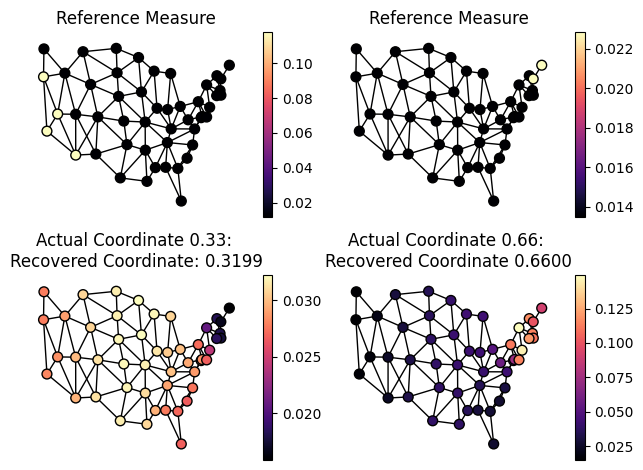

In [9]:
draw_fig(mu_0, mu_1, geodesic, coords, "sq-shortest-geodesic.pdf")

In [18]:
def draw_barycenter(m0, m1, m2, barycenter, coords, rc, fname, size=50, with_labels=False):
    fig, ax = plt.subplots(2,2, tight_layout=True)
    node_color=m0
    nx.draw(
        graph, 
        positions, 
        ax=ax[0][0], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[0][0])
    
    node_color=m2
    nx.draw(
        graph, 
        positions, 
        ax=ax[1][0], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[0][1])
    
    node_color=barycenter
    nx.draw(
        graph, 
        positions, 
        ax=ax[1][1], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[1][0])
    
    node_color=m1
    nx.draw(
        graph, 
        positions, 
        ax=ax[0][1], 
        node_size=size,
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    ax[0][0].set_title(f"Reference Measure")
    ax[0][1].set_title(f"Reference Measure")
    ax[1][0].set_title(f"Reference Measure")
    ax[1][1].set_title(f"Barycentric Coordinates ({coords[0]:.2f}, {coords[1]:.2f}, {coords[2]:.2f})\n Recovered: ({rc[0]:.4f}, {rc[1]:.4f}, {rc[2]:.4f})")
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[1][1])
    plt.savefig(os.path.join(img_dir, fname))

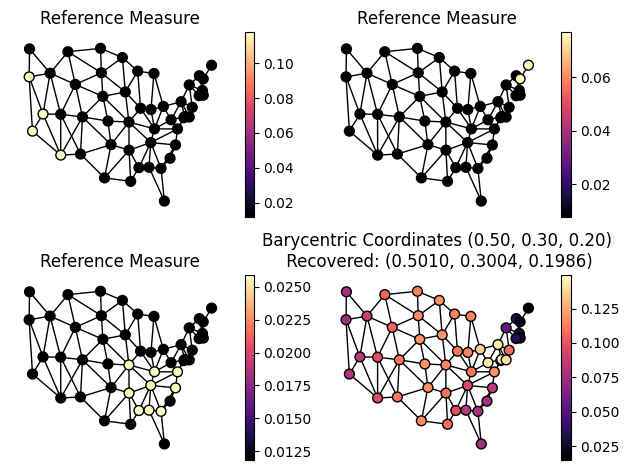

In [19]:
reg = 0.125
c0, c1, c2 = 15, 37, 22
coords = [0.5, 0.3, 0.2]
m0 = random_geographic_concentration(adj_mat, center=c0)
m1 = random_geographic_concentration(adj_mat, center=c1)
m2 = random_geographic_concentration(adj_mat, center=c2)
measures = np.stack((m0, m1, m2)).T
barycenter = total.barycenter(coords, measures, None, cost, reg)
fname = "barycenter.pdf"
rcs = total.simplex_regression(measures, barycenter, cost, reg)
draw_barycenter(m0, m1, m2, barycenter, coords, rcs, fname)